## Прогнозирование метрик с помощью библиотеки Orbit

Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От нас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.

__1. Выбрать основную метрику, которую планируем прогнозировать. Обосновать, почему именно она. Какое временное разрешение возьмём? Будут ли какие-то дополнительные регрессоры, которые включаем в модель?__     
Количество пользователей непосредственно влияет на нагрузку сервера. Чем больше пользователей активно, тем выше вероятность увеличения запросов к серверам, что может привести к подвисанию приложения. Таким образом, для прогнозирования выбираем метрику action.   
Временное разрешение можно выбрать на уровне часов, так как вам необходимо спрогнозировать изменения активности пользователей на ближайший месяц. Это позволит учесть дневную и часовую динамику активности, которая может быть важной для прогноза.   
Дополнительные регрессоры можно использовать, если есть информация о факторах, которые могут влиять на активность пользователей и, следовательно, на нагрузку на серверы. Так же должны знать будущие значения этих регрессоров. Это могут быть, например, маркетинговые кампании, праздники, обновления приложения и другие события. Добавление таких регрессоров может улучшить точность прогноза. Так как у нас нет данных на будущие события, то использование дополнительных регрессоров не предполагается.

__2. Построить модель и провалидировать её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определить, для какого горизонта прогнозирования у нас хватает данных.__

In [1]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
from orbit.eda import eda_plot
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
#общие штуки для кручения данных
import pandas as pd
import pandahouse
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

In [2]:
#подключаемся к схеме данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230820',
    'user':'student',
    'password':'dpo_python_2020'
}

#возьмем данные за 2 месяца (было бы замечательно если бы данные были в пропорции 80/20 или 70/30, но главное - не меньше прогнозируемого периода)
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    count(action) as action
FROM 
    simulator_20230820.feed_actions 
WHERE hour_time >= toDateTime('2023-07-11 00:00:00') 
  AND hour_time <= toDateTime('2023-09-12 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''
df= pandahouse.read_clickhouse(query, connection=connection)
df.head(3)

,hour_time,action
0,2023-07-11 00:00:00,10423
1,2023-07-11 01:00:00,8397
2,2023-07-11 02:00:00,6570


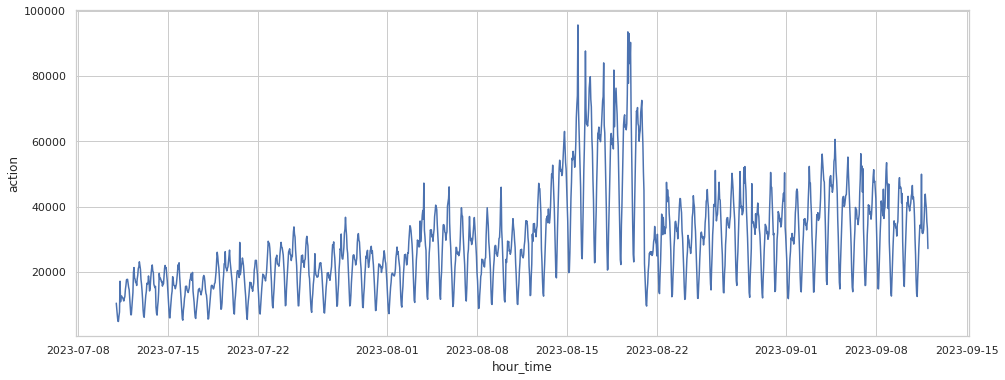

In [4]:
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")
#график изменения количества уникальных юзеров
sns.lineplot(x="hour_time", y="action", data=df);

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

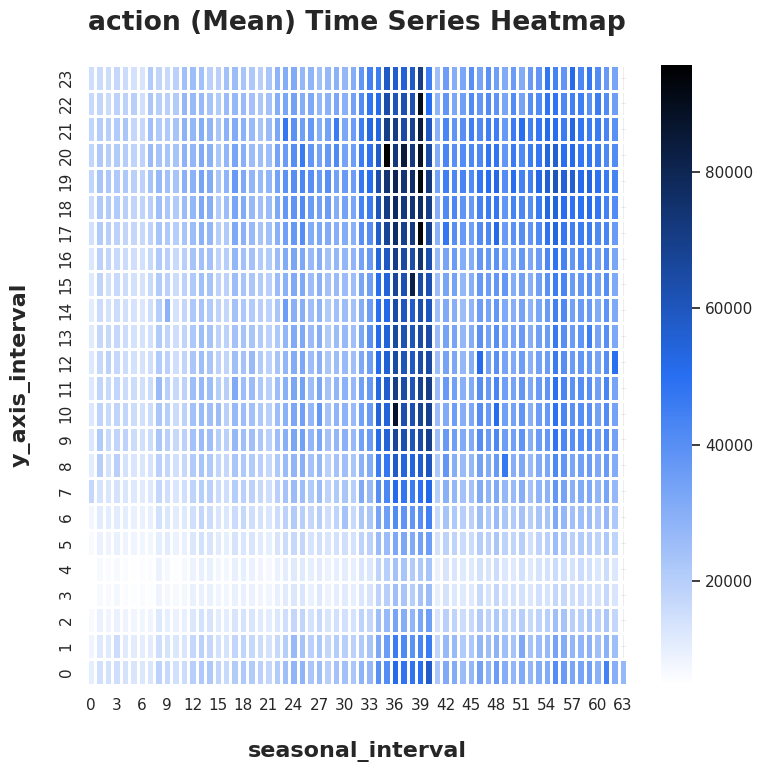

In [5]:
#тепловая карта
_ = eda_plot.ts_heatmap(df=df, date_col="hour_time", value_col="action", seasonal_interval=24, normalization=False)

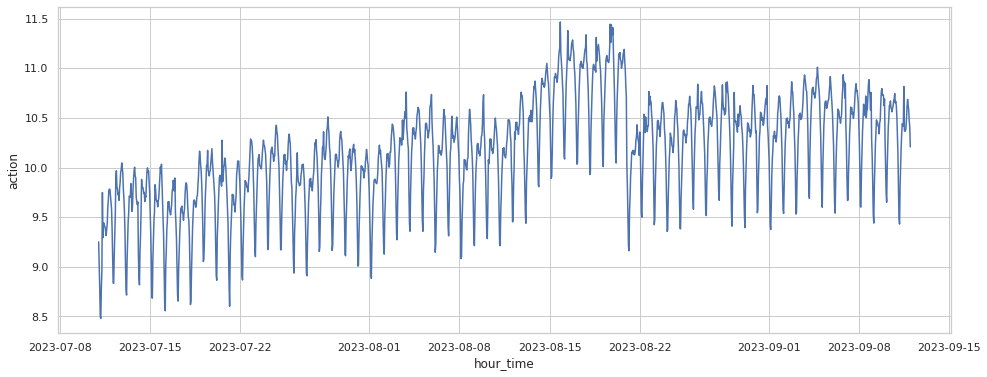

In [6]:
df_log = df.copy()
df_log['action'] = np.log(df['action']) #сделаем логарифмическое преобразование

#график логарифмического преобразования action
sns.lineplot(x="hour_time", y="action", data=df_log);

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

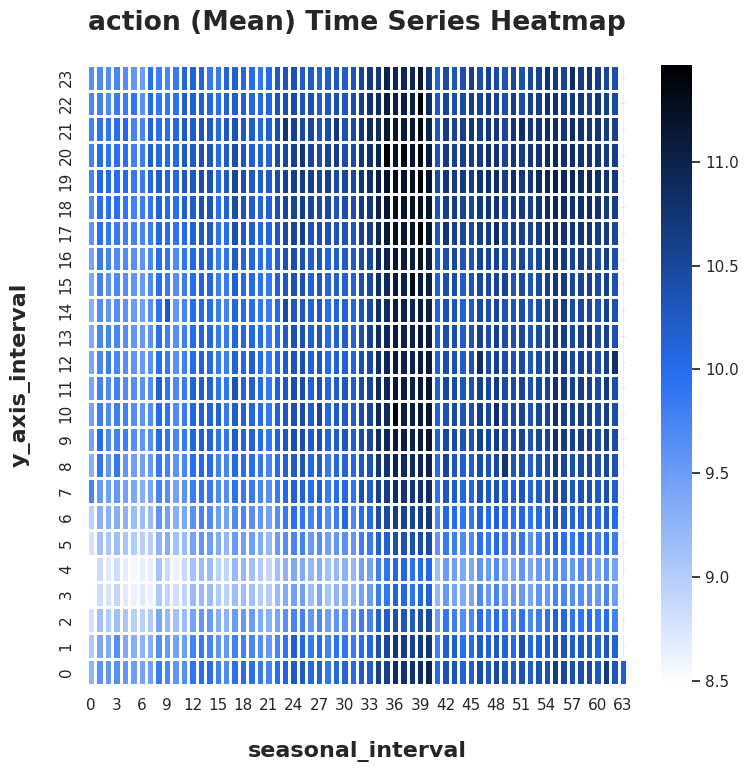

In [10]:
#тепловая карта логарифмического преобразования
_ = eda_plot.ts_heatmap(df=df_log, date_col="hour_time", value_col="action", seasonal_interval=24, normalization=False)

#### Строим модель DLT (MAP)

In [7]:
dlt_map = DLT(response_col="action", #название колонки с метрикой
          date_col="hour_time", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности
          global_trend_option="linear", #линейный тренд     
          estimator="stan-map", #алгоритм оценки  
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

dlt_map.fit(df_log)

2023-09-13 06:01:30 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [8]:
future_df_map = dlt_map.make_future_df(periods=24*30) #горизонт будет 30 дней - то есть 7 раз по 24 часа
future_df_map.head()

,hour_time
0,2023-09-12 01:00:00
1,2023-09-12 02:00:00
2,2023-09-12 03:00:00
3,2023-09-12 04:00:00
4,2023-09-12 05:00:00


In [9]:
predicted_df_dlt = dlt_map.predict(df=future_df_map, decompose=True) #c декомпозицией предсказания
predicted_df_dlt.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-09-12 01:00:00,9.967123,10.038558,10.113124,10.159117,10.230552,10.305118,-0.191994,-0.191994,-0.191994,0.0,0.0,0.0
1,2023-09-12 02:00:00,9.641108,9.744352,9.836376,10.126656,10.229900,10.321924,-0.485548,-0.485548,-0.485548,0.0,0.0,0.0
2,2023-09-12 03:00:00,9.312202,9.430536,9.553277,10.110924,10.229258,10.351999,-0.798722,-0.798722,-0.798722,0.0,0.0,0.0
3,2023-09-12 04:00:00,9.260048,9.394279,9.521905,10.094393,10.228624,10.356250,-0.834345,-0.834345,-0.834345,0.0,0.0,0.0
4,2023-09-12 05:00:00,9.593631,9.743206,9.880335,10.078421,10.227996,10.365125,-0.484790,-0.484790,-0.484790,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

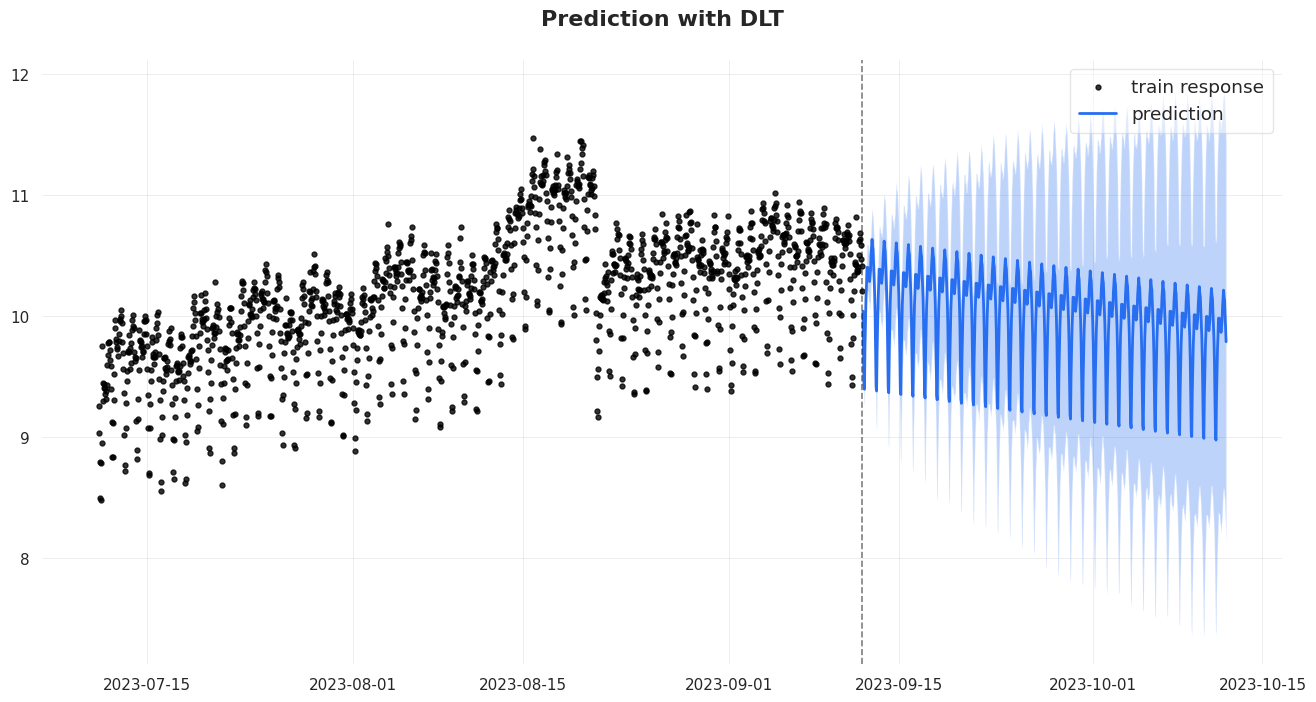

In [10]:
#нарисуем график прогноза
_ = plot_predicted_data(df_log, predicted_df_dlt, "hour_time", 'action', title='Prediction with DLT')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

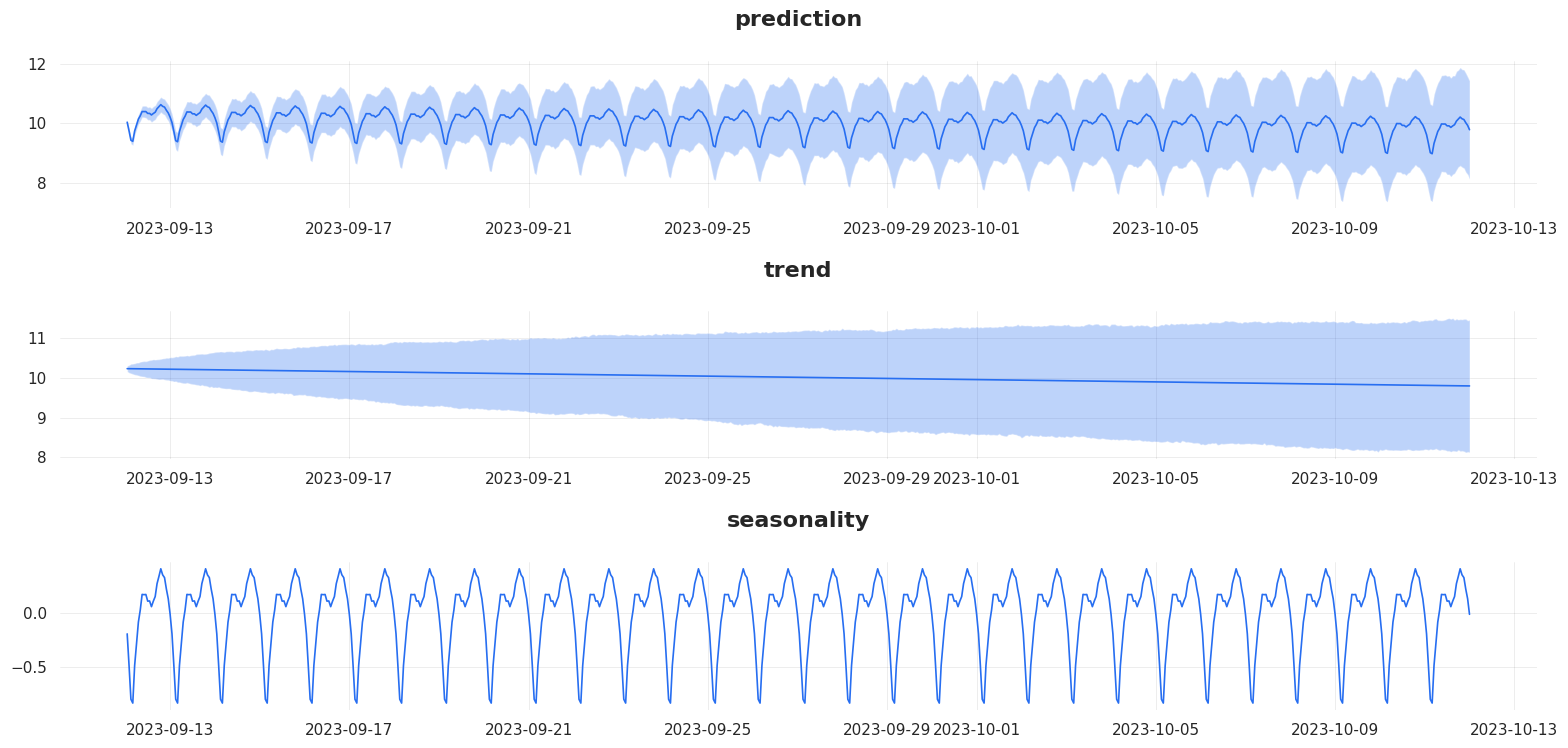

In [11]:
#нарисуем отдельные компоненты модели
_ = plot_predicted_components(predicted_df_dlt, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

#### Проверка качества моделей

In [12]:
bt_exp_dlt_map = BackTester(
    model=dlt_map, #наша моделька
    df=df_log, #датафрейм для обучения
    min_train_len=24*30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [13]:
bt_exp_dlt_map.fit_predict() #обучаем
bt_exp_dlt_map.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,0.040597,False
1,wmape,0.039921,False
2,mape,0.039498,False
3,mse,0.247558,False
4,mae,0.417567,False
5,rmsse,2.980631,False


#### Строим модель LGT (MCMC)

Метод Markov Chain Monte Carlo (MCMC) - ровная противоположность MAP! Он оценивает доверительные интервалы для всего, и имеет гораздо больше теоретических гарантий точности - но при этом не самый шустрый. Попробуем оценить модель с помощью него:

In [14]:
lgt_mcmc = LGT(seasonality=24, 
               response_col="action", 
               date_col="hour_time", 
               estimator='stan-mcmc', #новый алгоритм оценки
               num_warmup=2000, #время "разогрева"
               num_sample=1000) #время сэмплирования

lgt_mcmc.fit(df_log)

2023-09-13 06:02:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

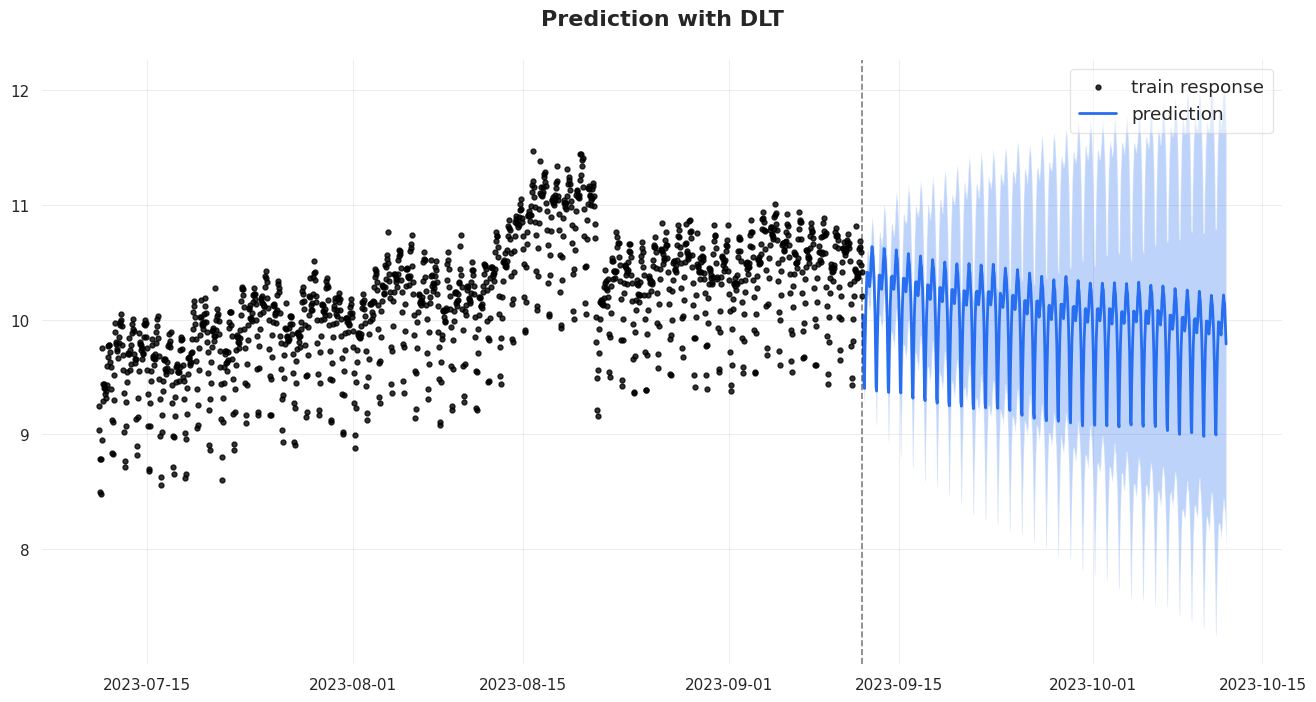

In [15]:
future_df_mcmc = lgt_mcmc.make_future_df(periods=24*30)
predicted_df_mcmc = lgt_mcmc.predict(df=future_df_mcmc)

_ = plot_predicted_data(df_log, predicted_df_mcmc, "hour_time", 'action', title='Prediction with DLT')

In [16]:
predicted_df_mcmc = lgt_mcmc.predict(df=future_df_mcmc, decompose=True)
predicted_df_mcmc.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-09-12 01:00:00,9.966939,10.037152,10.104447,10.161926,10.230617,10.295556,-0.202279,-0.193281,-0.182821,0.0,0.0,0.0
1,2023-09-12 02:00:00,9.647267,9.747201,9.838935,10.136486,10.233785,10.327816,-0.496349,-0.486942,-0.477017,0.0,0.0,0.0
2,2023-09-12 03:00:00,9.325628,9.435447,9.543160,10.125145,10.236369,10.339234,-0.809743,-0.799937,-0.789907,0.0,0.0,0.0
3,2023-09-12 04:00:00,9.271153,9.397584,9.524550,10.105874,10.232265,10.355952,-0.845575,-0.835485,-0.824552,0.0,0.0,0.0
4,2023-09-12 05:00:00,9.603836,9.746215,9.893175,10.086209,10.231711,10.380163,-0.495091,-0.485025,-0.474315,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

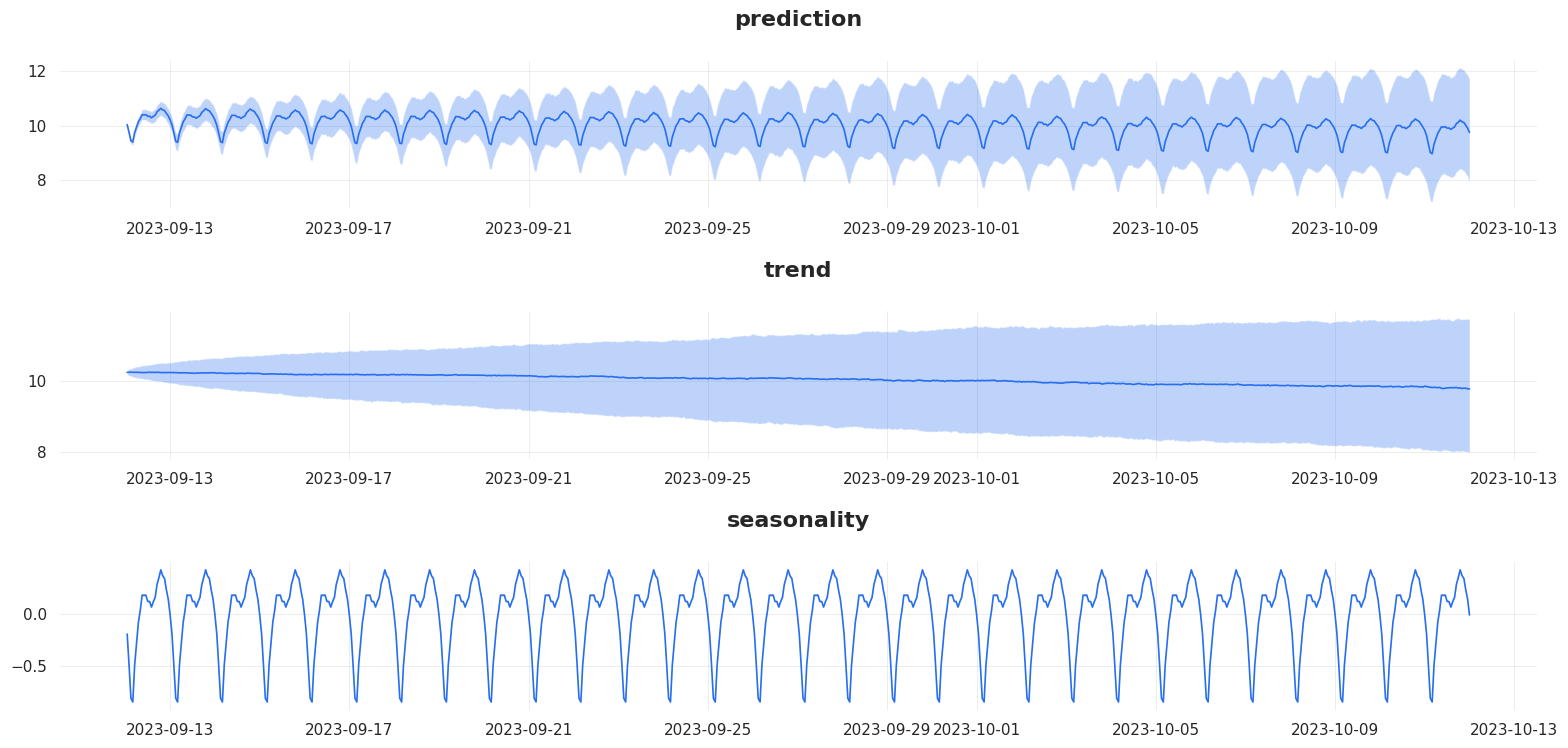

In [17]:
_ = plot_predicted_components(predicted_df_mcmc, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

#### Проверка качества моделей

In [18]:
bt_exp_mcmc = BackTester(
    model=lgt_mcmc, #наша моделька
    df=df_log, #датафрейм для обучения
    min_train_len=24*30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [19]:
bt_exp_mcmc.fit_predict() #обучаем
bt_exp_mcmc.score() #выводим метрики

2023-09-13 06:06:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-13 06:07:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-13 06:08:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-13 06:09:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,0.039961,False
1,wmape,0.039322,False
2,mape,0.038890,False
3,mse,0.241220,False
4,mae,0.411305,False
5,rmsse,2.942230,False


In [20]:
params = lgt_mcmc.get_posterior_samples(permute=False) #достаём информацию о параметрах
params.keys() #их названия - можно залезть в оригинальный код на Stan, чтобы вычислить их значение

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lgt_sum', 'gt_pow', 'lt_coef', 'gt_coef', 's', 'sea_sm', 'loglk'])

In [21]:
params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

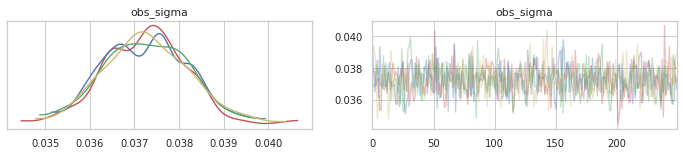

In [22]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

#### Строим модель LGT (MAP)

In [23]:
lgt_map = LGT(response_col="action",
          date_col="hour_time",
          seasonality=24,
          estimator="stan-map",  # Алгоритм оценки
          n_bootstrap_draws=1000)

lgt_map.fit(df_log)

2023-09-13 06:11:25 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

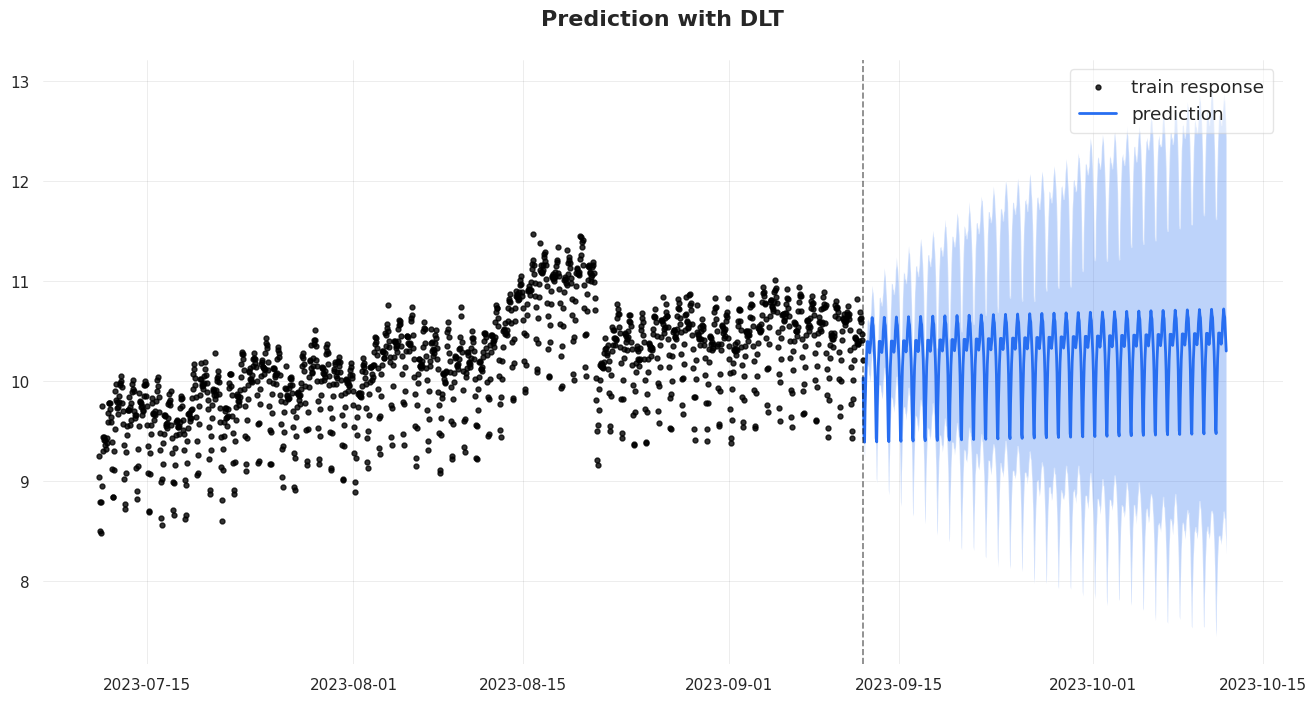

In [25]:
future_df_lgt_map = lgt_map.make_future_df(periods=24*30)
predicted_df_lgt_map = lgt_map.predict(df=future_df_lgt_map)

_ = plot_predicted_data(df_log, predicted_df_lgt_map, "hour_time", 'action', title='Prediction with DLT')

In [26]:
predicted_df_lgt = lgt_map.predict(df=future_df_lgt_map, decompose=True)
predicted_df_lgt.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-09-12 01:00:00,9.957718,10.030479,10.105072,10.145763,10.218524,10.293117,-0.188045,-0.188045,-0.188045,0.0,0.0,0.0
1,2023-09-12 02:00:00,9.629435,9.737155,9.832040,10.110928,10.218648,10.313533,-0.481493,-0.481493,-0.481493,0.0,0.0,0.0
2,2023-09-12 03:00:00,9.286546,9.423511,9.547071,10.081807,10.218772,10.342332,-0.795261,-0.795261,-0.795261,0.0,0.0,0.0
3,2023-09-12 04:00:00,9.233400,9.386146,9.527988,10.066149,10.218895,10.360737,-0.832749,-0.832749,-0.832749,0.0,0.0,0.0
4,2023-09-12 05:00:00,9.567650,9.734823,9.894833,10.051846,10.219019,10.379029,-0.484196,-0.484196,-0.484196,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

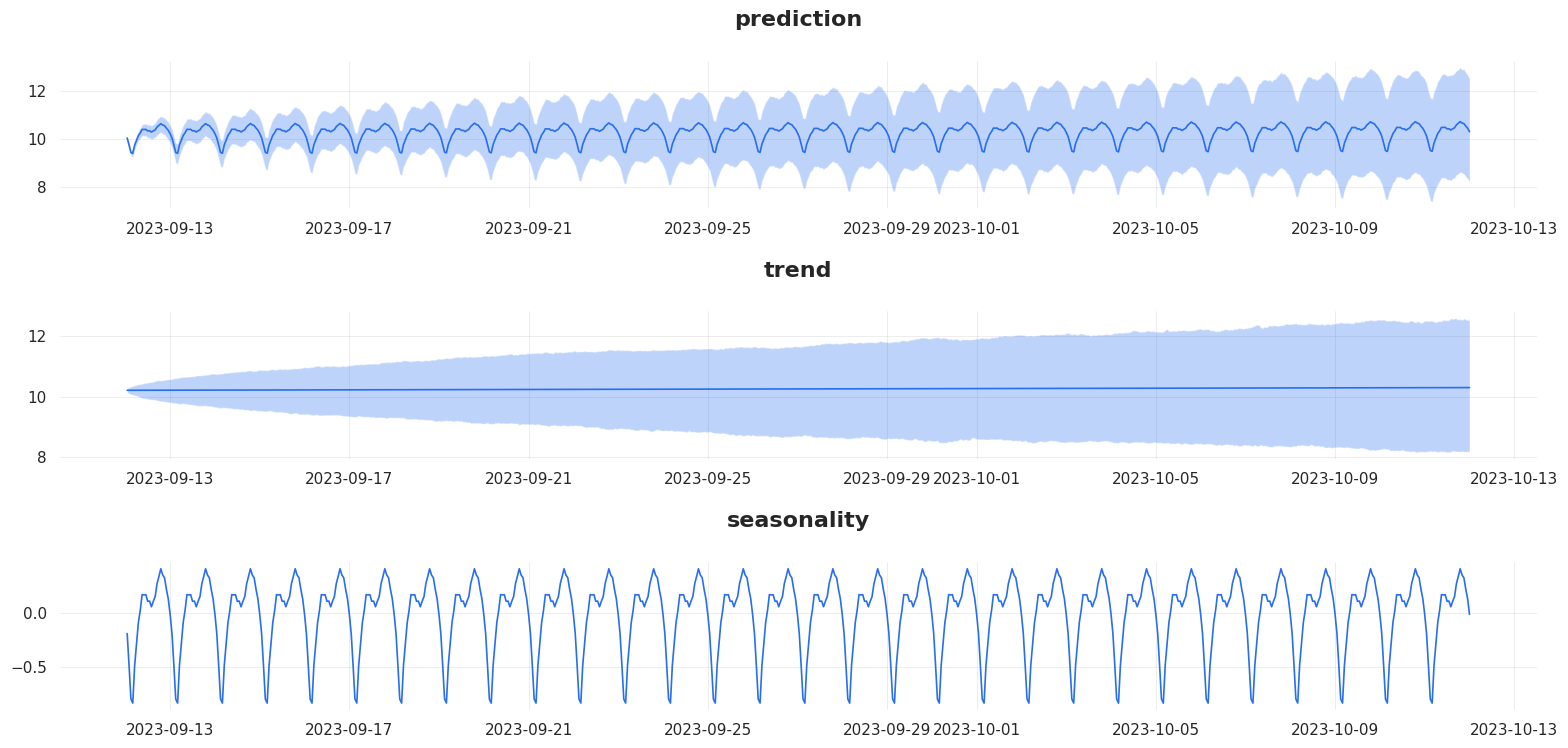

In [27]:
_ = plot_predicted_components(predicted_df_lgt, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

### Проверка качества моделей

In [28]:
#expanding
bt_exp_lgt = BackTester(
    model=lgt_map, #наша моделька
    df=df_log, #датафрейм для обучения
    min_train_len=24*30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [29]:
bt_exp_lgt.fit_predict() #обучаем
bt_exp_lgt.score() #метрики модели LGT (MAP)

,metric_name,metric_values,is_training_metric
0,smape,0.033273,False
1,wmape,0.033091,False
2,mape,0.032733,False
3,mse,0.173817,False
4,mae,0.346128,False
5,rmsse,2.497560,False


__3. Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты.__

In [30]:
#метрики модели DLT (MAP)
bt_exp_dlt_map.score()

,metric_name,metric_values,is_training_metric
0,smape,0.040597,False
1,wmape,0.039921,False
2,mape,0.039498,False
3,mse,0.247558,False
4,mae,0.417567,False
5,rmsse,2.980631,False


In [31]:
#метрики модели LGT (MCMC)
bt_exp_mcmc.score()

,metric_name,metric_values,is_training_metric
0,smape,0.039961,False
1,wmape,0.039322,False
2,mape,0.038890,False
3,mse,0.241220,False
4,mae,0.411305,False
5,rmsse,2.942230,False


In [32]:
#метрики модели LGT (MAP)
bt_exp_lgt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.033273,False
1,wmape,0.033091,False
2,mape,0.032733,False
3,mse,0.173817,False
4,mae,0.346128,False
5,rmsse,2.497560,False


__Вывод:__   
На основании полученных метрик следует выбрать модель LGT с методом оценки MAP (Maximum A Posteriori Estimation) как наиболее удачную для нашей задачи прогнозирования. Это свидетельствует о том, что данная модель обеспечивает наилучшую точность прогнозирования по сравнению с другими рассмотренными моделями (LGT MCMC и DLT MAP).   
К примеру, SMape = 0.033273 - средняя абсолютная процентная ошибка между прогнозируемыми и фактическими значениями составляет около 3.33%. Такой низкий уровень ошибки свидетельствует о том, что модель LGT MAP хорошо справляется с прогнозированием активности пользователей.

Выводим результаты прогноза:

In [33]:
columns = ['prediction_5', 'prediction', 'prediction_95', 'trend_5', 'trend', 'trend_95', 'seasonality_5', 'seasonality', 'seasonality_95', 'regression_5', 'regression', 'regression_95']

# Применение обратной трансформации к каждой колонке
for column in columns:
    predicted_df_lgt[column] = np.exp(predicted_df_lgt[column])

In [34]:
predicted_df_lgt #предсказанные значения

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-09-12 01:00:00,21114.556607,22708.143104,24466.795813,25482.901280,27406.181420,29528.677960,0.828577,0.828577,0.828577,1.0,1.0,1.0
1,2023-09-12 02:00:00,15205.847314,16935.287341,18620.904417,24610.496664,27409.576330,30137.729032,0.617860,0.617860,0.617860,1.0,1.0,1.0
2,2023-09-12 03:00:00,10791.841579,12375.953052,14003.613509,23904.134589,27412.971664,31018.270570,0.451463,0.451463,0.451463,1.0,1.0,1.0
3,2023-09-12 04:00:00,10233.271142,11922.068593,13738.926309,23532.755190,27416.367422,31594.471106,0.434852,0.434852,0.434852,1.0,1.0,1.0
4,2023-09-12 05:00:00,14294.780831,16895.850392,19827.657892,23198.566634,27419.763605,32177.705154,0.616192,0.616192,0.616192,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2023-10-11 20:00:00,5228.368052,42714.176036,401522.943096,3665.355075,29944.834925,281488.294821,1.426428,1.426429,1.426429,1.0,1.0,1.0
716,2023-10-11 21:00:00,5008.403395,41615.545253,408958.367679,3604.287999,29948.546063,294306.043183,1.389568,1.389568,1.389569,1.0,1.0,1.0
717,2023-10-11 22:00:00,4533.078804,37448.951277,356444.153305,3625.625984,29952.257662,285089.643039,1.250288,1.250288,1.250289,1.0,1.0,1.0
718,2023-10-11 23:00:00,4092.354719,34268.947766,320951.158843,3577.304439,29955.969723,280557.182148,1.143977,1.143977,1.143978,1.0,1.0,1.0


__Бонус:__ опишите, насколько удобным для использования вам показался Orbit. Если есть опыт использования других прогнозных инструментов (Prophet, Darts и т.д.) – сравните Orbit с ними по тем признакам, которые вам кажутся наиболее важными.

Работать с библиотекой Prophet для меня было легче, она проще в использовании и быстрее обрабатывает действия, но у Orbit более широкий выбор моделей и настроек.